<a href="https://colab.research.google.com/github/yucachen/MLTSA25_YChen/blob/main/HW5/HW5_chchchchanges_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jacklyn Clauss imported necessary python packages, created synthetic data, did point of change detection methods (without rupture), imported LANL earthquake data, and helped tested the rupture package. Yuca Chen and Skyler Lindsey helped tested different models for detecting point of change using rupture, set up code for using rupture, and searched for methods to use from rupture.Everyone also worked on troubleshooting the runtime for some Rupture calculations. Dayanara Yanez followed along with the code and learned the techniques.


Division of Work (everyone wrote individual captions):

*   Jacklyn Clauss: importing packages, creation of synthetic data, point of change detection without rupture, importing of LANL earthquake data, testing of rupture package
*   Yuca Chen: testing out different models for rupture point of change, setting up code for using rupture, search of methods to use from rupture
*   Skyler Lindsey: testing out different models for rupture point of change, setting up code for using rupture, search of methods to use from rupture
*   Dayanara Yanez: followed along with the code and learned



In [ ]:
!pip install ruptures
import ruptures as rpt
import pylab as pl
import pandas as pd
%pylab inline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [ ]:
# added in: import numpy to handle arrays
import numpy as np
#import scipy
import scipy

# Synthetic data
the cell below creates a synthetic dataset _(x,y)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(0,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and 25 respectively.

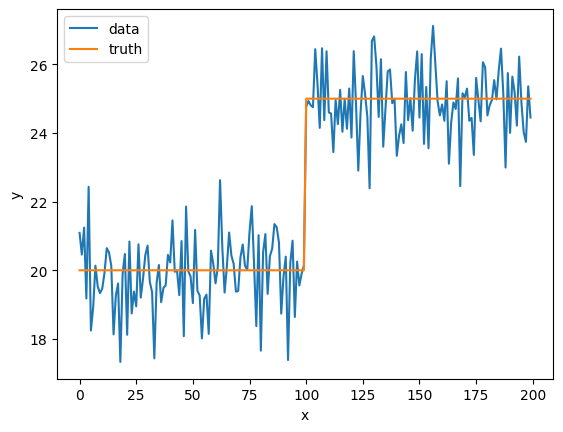

In [ ]:
np.random.seed(302)
mu1, mu2 = 20, 25
x = np.arange(200)
ym = np.concatenate([np.random.randn(100) + mu1, np.random.randn(100) + mu2])
pl.plot(x, ym, label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, label="truth")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();

**Figure 1:** A synthetic dataset is shown in the solid blue line, made of random points centered around two different means. A point of change can be seen at around 100 in the x-axis, where the data seems to change from one mean to another. The true values are shown in the solid orange line, where the two average values are denoted in the solid orange line with a step at 100 in the x-axis, demonstrating the point of change.  

# Single POC -  difference of means
write a function that finds the POC by assuming a single POC and maximizing the differencem in the means before and after the POC as described in
https://slides.com/federicabianco/mltsa4#/6/1
test it on the synthetic dataset _(x,y)_

In [ ]:
def maxdiff(y):
    """calculates the POC as the points that maximized the difference between the mean before and the mean after the POC
    y: vector of endogenouos variables

    """
    N = len(y)
    f = np.nanmean
    poc, diff, before, after = 0, 0, np.nan, np.nan
    for i in range(1, N):
        diff_here = np.abs(f(ym[i:]) -  f(ym[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(ym[:i]), f(ym[i:])
    return(poc, before, after)

print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*maxdiff(ym)))


poc: 100.00, mean before: 19.89, mean after: 24.90


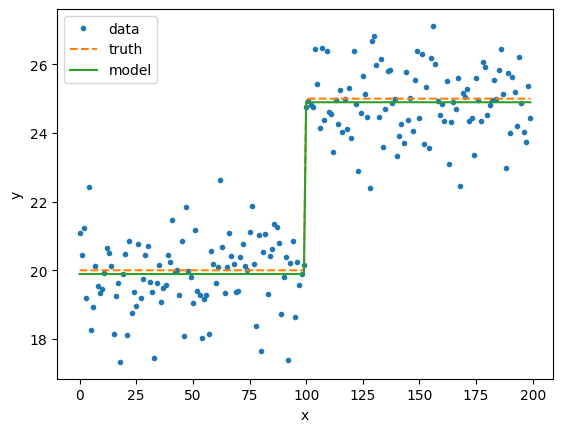

In [ ]:
poc, before, after = maxdiff(ym)
pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [before] * poc + [after] * (len(ym) - poc), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Figure 2:** A synthetic dataset is shown in the solid blue dots, made of random points centered around two different means. A point of change can be seen at around 100 in the x-axis, where the data seems to change from one mean to another. The true values of the data are shown in the dotted orange line, where the two average values are denoted in the solid orange line with a step at 100 in the x-axis, demonstrating the point of change.  The model of the data is seen in the solid green line and is obtained by minimizing and maximizing the difference in means before and after the point of change, where the point of change in the model visually lines up with the expected true values.

# Single POC - MSE
write a function that finds the POC by minimizing the square error (see slide https://slides.com/federicabianco/mltsa4#/6/2) a single POC and maximizing the differencem in the means before and after the POC. like before return the index of the POC, the mean before and the mean after the POC.
Plot the data, the model, the truth, like in the step above.


Remember to write a docstring for the function https://www.python.org/dev/peps/pep-0257/!

**Comments from Jacklyn:** In this function the new point of change will only be accepted if the difference in the means before and after becomes larger and the value of the squared error becomes smaller. Here the condition on the difference in means is checked for first, and then the condition on the square error. I have tried doing this the opposite way, where the condition for the square error is checked first, and the results were the same.

In [ ]:
def square_error(a,b):
    """
    Return the square error between data points and a model

    Input:
      a: array of data points
      b: array of model points

    Output:
      square error: the square error between the data and the model
    """
    return np.sum((a - b)**2)


def poc_mse(y):
    """
    Find the POC by assuming a single POC and minimizing the square error, as well as
    maximizing the difference in the means before and after the POC.

    Input:
      y: array of data for the endogenous variable

    Output:
      poc: index of the point of change
      before: mean before the point of change
      after: mean after the point of change
    """

    N = len(y)
    f = np.nanmean
    poc, diff, se, before, after = 0, 0, 1_000_000, np.nan, np.nan
    # This will find the state of change by maximizing the difference between the means before and after the poc

    for i in range(1, N):
        diff_here = np.abs(f(y[i:]) -  f(y[:i]))
        # we are maximizing the difference between the means before and after
        if diff < diff_here:
            diff_g = diff_here
            # the '_g' in these variable names represents that they are based only on maximizing the
            # difference in the mean before and after.
            poc_g = i
            before_g, after_g= f(y[:i]), f(y[i:])

            # create the model based on the point of the change determined here
            y_model = [before_g] * poc_g + [after_g] * (len(y) - poc_g)
            # find the square error of this model
            se_here = square_error(y, y_model)
            #print(se_here)

            # if the squared error is smaller here, set the variables to be what it is at this point
            if se_here < se:
                se = se_here
                poc, before, after = poc_g, before_g, after_g
                diff = diff_g

    return(poc, before, after)


In [ ]:
print("poc: {:.2f}, mean before: {:.2f}, mean after: {:.2f}".format(*poc_mse(ym)))


poc: 100.00, mean before: 19.89, mean after: 24.90


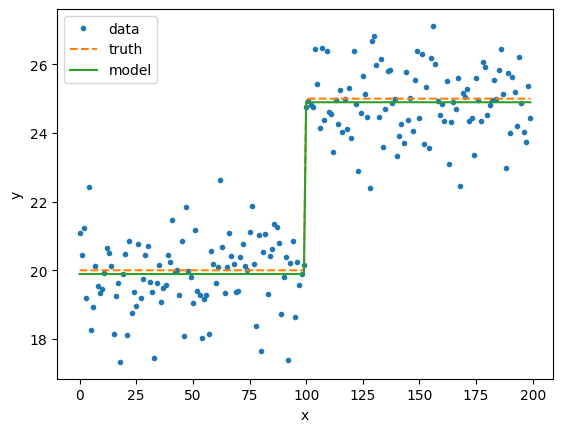

In [ ]:
pocmse, beforemse, aftermse = poc_mse(ym)

pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [beforemse] * pocmse + [aftermse] * (len(ym) - pocmse), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Figure 3:** A synthetic dataset is shown in the solid blue dots, made of random points centered around two different means. A point of change can be seen at around 100 in the x-axis, where the data seems to change from one mean to another. The true values of the data are shown in the dotted orange line, where the two average values are denoted in the solid orange line with a step at 100 in the x-axis, demonstrating the point of change.  The model of the data is seen in the solid green line and is obtained by minimizing the square error, where the point of change in the model visually lines up with the expected true values.

# Single POC - diff of variance
Generate a new synthetic dataset _(x,ys)_ of 200 points, generated by two processes $ y =c + \epsilon$ with $\epsilon \sim N(\sigma,1)$ (Gaussian stationary processes) that generate 100 points each with means 20 and variance 1 and 4 respectively.

Modify the ```maxdiff()``` function so that it take an optional parameter sigma which allows you to use the function to choose the POC that maximizes the different in standard deviation, instead of in mean. An optional argument is an argument that is set to a default in the function call. The default behavior of the function shoudl still be to calculate the POC as the point that maximized the before and after difference in the _mean_.


In [ ]:
# this cell creates the new synthetic dataset using gaussian stationary processes
mu1, mu2 = 20, 25
s1 = 1
s2 = 4
ys = np.concatenate([np.random.randn(100)  + mu1 , np.random.randn(100) * s2 + mu1])

**Note from Jacklyn on making this work:** When finding the POC based on the differende in standard deviation, we need to exclude the first and last points of the data set. At the first point of the data, the data before will only consist of one point, and so the standard deviation before will be zero. This will make the difference between the standard deviations artificially large, and will mark this as the point of change even though it is not. The same happens with the last data point, except the standard deviation after will be zero.

In [ ]:
def maxdiff(y, sigma=False):

    """
    Calculates the POC as the points that maximized the difference between
                the mean or variance before and the mean after the POC
    Input:
      y: vector of endogenouos variables
      sigma: finds the POC that maximizes the difference between before/after POC variance
                (optional, default is before/after mean)
    Output:
      poc: index of the point of change
      before: mean or variance before the point of change
      after: mean or variance after the point of change
    """

    N = len(y)

    # if sigma is false, find the poc based on the maximum difference in means as before.
    if not sigma:
      # print statement for testing
      #print("sigma is False, use mean")

      f = np.nanmean
      poc, diff, before, after = 0, 0, np.nan, np.nan

      for i in range(1, N):
        diff_here = np.abs(f(y[i:]) -  f(y[:i]))
        if diff < diff_here:
            diff = diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
      return(poc, before, after)

    # if sigma is true, find the POC based on the maximum differece in the standard deviation
    else:
      # print statement for testing
      #print("sigma is True, use standard deviation")

      # redefine the function f to find the standard deviation
      f = np.std
      poc, std_diff, before, after = 0, 0, np.nan, np.nan

      #loop through each possible value for the POC
      # NOTE: we must exclude the first and last data points in the array
      for i in range(2, N-1):
        std_diff_here = np.abs(f(y[i:]) -  f(y[:i]))

        # if the difference in standard deviation is larger at this point, it is a
        # better candidate for the POC
        if std_diff < std_diff_here:
            std_diff = std_diff_here
            poc = i
            before, after = f(y[:i]), f(y[i:])
      # return the poc, before and after of the POC with the greatest difference in standard deviation
      return(poc, before, after)


print("poc: {:.2f}, Standard deviation before: {:.2f}, Standard deviation after: {:.2f}".format(*maxdiff(ys,
                                                                    sigma=True)))


poc: 106.00, Standard deviation before: 1.07, Standard deviation after: 4.73


In [ ]:
print(np.std(ys[:100]))

1.0305022895511642


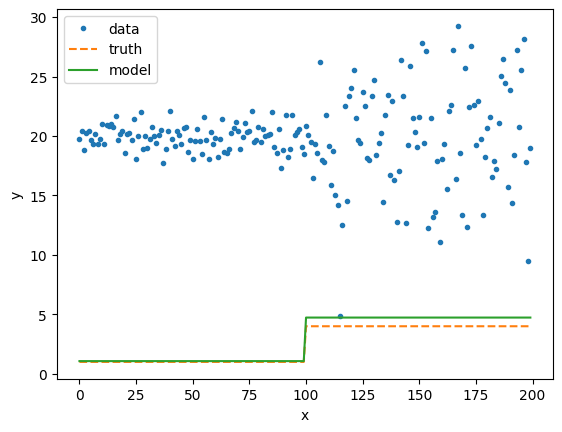

In [ ]:
# find the point of change in our new synthetic data set based on standard deviation

poc, before, after = maxdiff(ys, sigma=True)
#plot the synthetic data set
pl.plot(x, ys, '.', label="data")

pl.plot(range(200), [s1] * 100 + [s2] * 100, '--', label="truth")

pl.plot(range(200), [before] * 100 + [after] * 100, '-', label="model")
pl.xlabel('x')
pl.ylabel('y')
pl.legend()

**Figure 4:** A synthetic dataset is shown in the solid blue dots, made of random points centered around a mean with two different standard deviations. A point of change can be seen at around 100 in the x-axis, where the data seems to change from one mean to another. The true values of the standard deviation are shown in the dotted orange line, where the two average values are denoted in the solid orange line with a step at 100 in the x-axis, demonstrating the point of change.  The model of the standard deviation is seen in the solid green line and is obtained by minimizing the square error, where the point of change in the model visually lines up with the expected true values.

# Choose any of the function above and instead of optimizing them with a ``brute force'' method (i.e. with a for loop), use the `scipy.optimize.minimize` function (as done in the notebook about fitting lines to data).

In [ ]:
def square_error_of_poc(params,data):
    """
    Return the square error between data points and a model

    Input:
      data: array of data points
      poc: index of the point of change

    Output:
      square error: the square error between the data and the model
    """

    f = np.nanmean

    # The optimized point of change may not always be an integer so we must ensure
    # that it is in order to slice the data into before and after
    poc = int(np.round(params[0]))

    before = f(data[:poc])
    after = f(data[poc:])

    y_model = [before] * poc + [after] * (len(data) - poc)
    print(y_model)

    return np.sum((data - y_model)**2)


def poc_mse_opt(y):
    """
    Find the POC by assuming a single POC and minimizing the square error using scipy.minimize, as well as
    maximizing the difference in the means before and after the POC.

    Input:
      y: array of data for the endogenous variable

    Output:
      poc: index of the point of change
      before: mean before the point of change
      after: mean after the point of change
    """

    N = len(y)
    f = np.nanmean
    poc, diff, se, before, after = 0, 0, 1_000_000, np.nan, np.nan
    # This will find the state of change by maximizing the difference between the means before and after the poc

    x0 = 100

    poc = scipy.optimize.minimize(square_error_of_poc, 80, args = y).x[0]

    #round the optimized poc to the nearest integer
    poc = int(np.round(poc))

    before = f(y[:poc])
    after = f(y[poc:])

    return(poc, before, after)

[np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.float64(19.87785418170244), np.floa

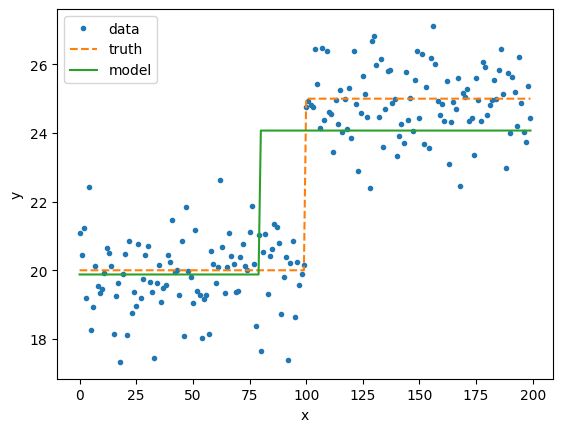

In [ ]:
pocmse, beforemse, aftermse = poc_mse_opt(ym)

pocmse = np.round(pocmse)

pl.plot(x, ym, '.', label="data")
pl.plot(range(200), [mu1] * 100 + [mu2] * 100, '--', label="truth")
pl.plot(x, [beforemse] * pocmse + [aftermse] * (len(ym) - pocmse), label="model")
pl.xlabel('x')
pl.ylabel('y');
pl.legend();

**Figure 5:** A synthetic dataset is shown in the solid blue dots, made of random points centered around two different means. A point of change can be seen at around 100 in the x-axis, where the data seems to change from one mean to another. The true values of the data are shown in the dotted orange line, where the two average values are denoted in the solid orange line with a step at 100 in the x-axis, demonstrating the point of change.  The model of the data is seen in the solid green line and is obtained by using scipy.optimize, where the point of change in the model now differs from the truth by ~25 on the x-axis.

# Find POC with rupture python package.
install and import the rupture package.
Find the POC in each synthetic time series.
Use the Pelt method. Reflect on the parameters that should be passed to the predict() function. Read the manual and feel free to ask questions on slack.

**Comments:**

The pelt function takes a model input which represents the loss function to be used. Here the l2 model was used since we have been using squared error in this assignment.

**Reflection on values passed into prediction:** The only argument taken by algo.predict() is a float representing the penalty value, and must be greater than zero. A larger penalty value penalizes the model more for finding many breakpoints. In this case we know that there is only one breakpoint so we should pass in a fairly large penalty value. pen = 10 appears to work well for these purposes.

In [ ]:
# to view the docstring for predict
# algo.predict?
# rpt.Pelt?

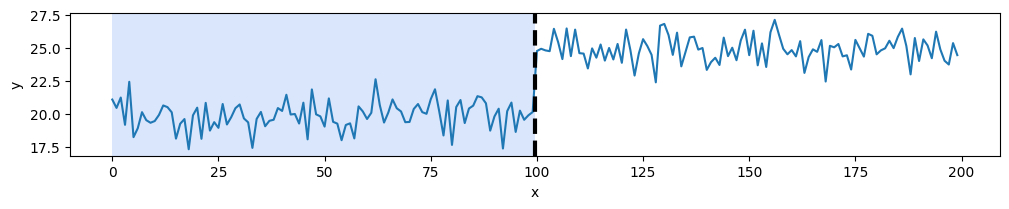

In [ ]:
# detection

algo = rpt.Pelt(model='l2').fit(ym)
result = algo.predict(pen=10)

# display
rpt.display(ym, [100], result)
pl.xlabel('x')
pl.ylabel('y')
pl.show()

**Figure 6:** A synthetic dataset is shown in the solid blue line, made of random points centered around two different means. A point of change found by Rupture using the L2 model is denoted in the dotted vertical black line, seen at 100 in the x-axis. The blue shaded part represents the values around one mean, while the non-shaded part represents the values around another mean. The point of change found by Rupture appears to line up with the point of change seen in the data, also at 100 in the x-axis.

/usr/local/lib/python3.11/dist-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


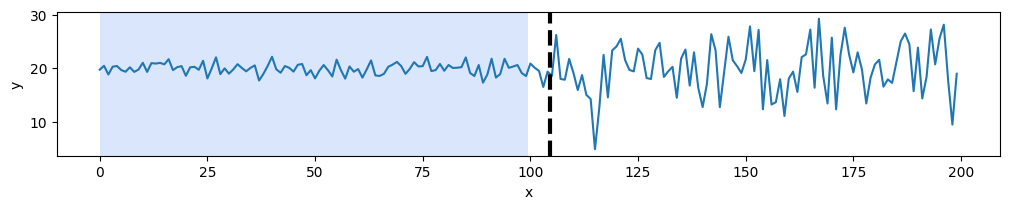

In [ ]:
# detection for standard deviation data

algo = rpt.Pelt(model='normal').fit(ys)
result = algo.predict(pen=10)

# display
rpt.display(ys, [100], result)
pl.xlabel('x')
pl.ylabel('y')
pl.show()

**Figure 7:** A synthetic dataset is shown in the solid blue dots, made of random points centered around a mean with two different standard deviations. A point of change found by Rupture using the normal model is denoted in the dotted vertical black line, seen at ~105 in the x-axis. The blue shaded part represents the values around one mean, while the non-shaded part represents the values around another mean. The point of change found by Rupture does seem to line up with the point of change seen in the data, which is also slightly above 100 in the x-axis.

**Note:** Looking at the docstring for rpt.Pelt, I suspect that to find the point of change of the standard deviation we may have to use the custom_cost option. The results of this are not what we expect. Might need to create a custom model rather than a custom cost? I'm not sure if this is event possible and the documentation is hard to understand.

In [ ]:
# class MyCost(rpt.base.BaseCost):
#   model = "l2"
#   min_size = 2

#   def fit(self, signal):
#         """Set the internal parameter."""
#         self.signal = signal
#         return self

#   def error(self, start, end):
#         """Return the approximation cost on the segment [start:end].

#         Args:
#             start (int): start of the segment
#             end (int): end of the segment

#         Returns:
#             float: segment cost
#         """
#         sub = self.signal[start:end]

#         return (np.std(sub))



In [ ]:
# class MyModel(rpt.costs.CostNormal):

#   def fit(self, signal):
#         """Set the internal parameter."""
#         self.signal = signal
#         return self

#   def compute(self, start, end):
#         """Return the approximation cost on the segment [start:end].

#         Args:
#             start (int): start of the segment
#             end (int): end of the segment

#         Returns:
#             float: segment cost
#         """

#         sub = self.signal[start:end]
#         return np.std(sub)

In [ ]:
# my_model = MyModel().fit(ys)
# my_model.fit(ys)

# # detection
# algo = rpt.Pelt(model=my_model).fit(ys)
# result = algo.predict(pen=1)

# # display
# rpt.display(ys, [100], result)
# pl.show()

In [ ]:
# # prompt: use the python rupture package to detect the point of change in the standard deviation in the "ys" array

# import numpy as np
# import ruptures as rpt
# # Assuming 'ys' is defined from the previous code

# # Detection using Pelt method with a custom cost function for standard deviation
# # Create a custom cost function that calculates the standard deviation of a segment
# class StdDevCost(rpt.base.BaseCost):
#     model = "l2"
#     min_size = 2
#     def fit(self, signal):
#         self.signal = signal
#         return self
#     def error(self, start, end):
#         return np.std(self.signal[start:end])



# # Initialize Pelt algorithm with the custom cost function
# algo = rpt.Pelt(model = 'l2',custom_cost=StdDevCost(), jump=1).fit(ys)

# # Predict change points with a penalty
# result = algo.predict(pen=0.2)

# # Display the results
# rpt.display(ys, [100], result)
# pl.xlabel('x')
# pl.ylabel('y')
# pl.show()


# read in the data from LANL earthquake prediction
I saved in the github repo as "http://fbb.space/mltsa/LALNeq.csv. This is a large file and will take a long time to read in. It is 1/100th of the original file. See how nice I am!?! https://www.kaggle.com/c/LANL-Earthquake-Prediction/data

Visualize and use the method DataFrame.describe() to extract some basic statistics of the dataset

In [ ]:
eq1 = pd.read_csv("http://fbb.space/mltsa/LALNeq.csv", index_col=0)
eq1.describe()

,acoustic_data,time_to_failure
count,4.500000e+06,4.500000e+06
mean,4.616407e+00,8.852012e-01
std,2.614006e+01,3.374432e-01
min,-4.621000e+03,3.008971e-01
25%,2.000000e+00,5.934956e-01
50%,5.000000e+00,8.849986e-01
75%,7.000000e+00,1.177597e+00
max,3.252000e+03,1.469100e+00


In [ ]:
eq1.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


# using rupture

Go through the documentation of rupture.

Find a method that takes as input the number of pocs and has computational complexity O(kN^2) and run it for k=1,2,3 pocs on the first N=10,000, 5000, and 1000 rows of the datasets respectively (make a plot for each and discuss each in the caption)

Dynamic programming: https://centre-borelli.github.io/ruptures-docs/user-guide/detection/dynp/




In [ ]:
inputData_10000 = eq1.acoustic_data.values[:10000]
inputData_5000 = eq1.acoustic_data.values[:5000]
inputData_1000 = eq1.acoustic_data.values[:1000]

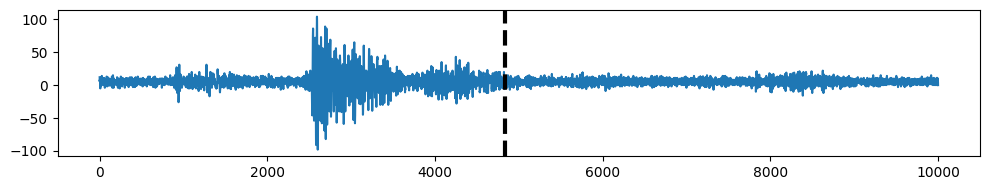

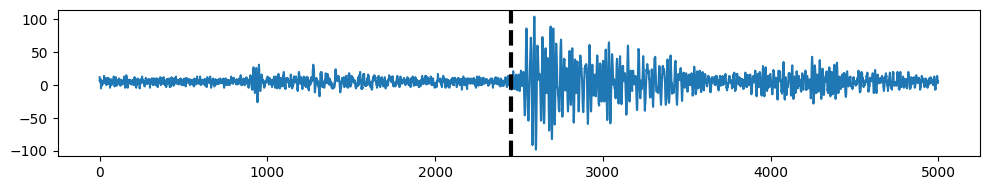

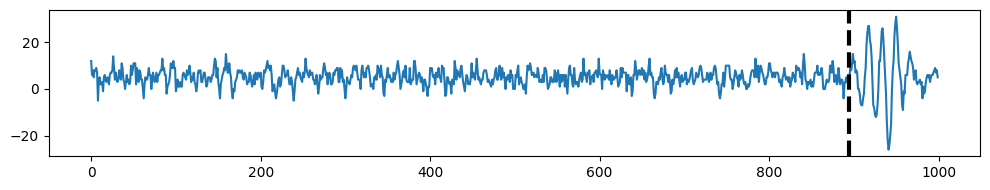

In [ ]:
# ---------- for k = 1 (n_bkps=1) ----------

algo1 = rpt.Dynp(model="rbf").fit(inputData_10000)
result = algo1.predict(n_bkps=1)

rpt.display(eq1.acoustic_data.values[:10000], [], result)
plt.show()

# -------

algo2 = rpt.Dynp(model="rbf").fit(inputData_5000)
result = algo2.predict(n_bkps=1)

rpt.display(eq1.acoustic_data.values[:5000], [], result)
plt.show()

# -------

algo3 = rpt.Dynp(model="rbf").fit(inputData_1000)
result = algo3.predict(n_bkps=1)

rpt.display(eq1.acoustic_data.values[:1000], [], result)
plt.show()


**Figure 8:** The acoustic data from the LANL earthquake prediction data as a function of the number of datapoints is shown in all of the subgraphs. The top subgraph has the first 10,000 datapoints, the middle subgraph has the first 5,000 datapoints, the bottom subgraph has the first 1,000 datapoints. The Dynamic programming method is used with the rbf model in Rupture for all three subgraphs. The Dynamic programming method has a computational complexity of O(kN^2). A single point of change is calculated in all three of the graphs, seen at ~4750, ~2500, and ~900 in the x-axis in the top, middle, and bottom graph, respectively. The different points of change between the three graphs, though the middle and bottom graph are subsets of the top graph, show how the input data influences what the computation may consider as a point of change (as it is calculated relative to the input data given). This point of change can be seen, for earthquake acoustic data, when an earthquake potentially starts or ends (though this is not visually obvious from the top graph).

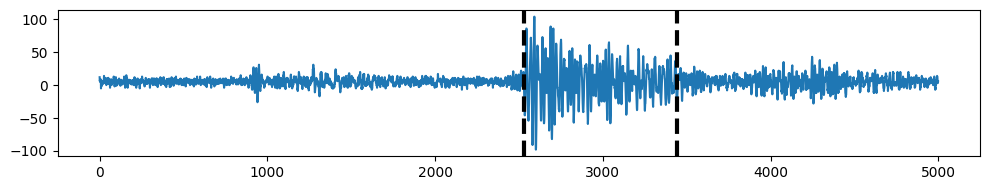

In [ ]:
# ---------- for k = 2 (n_bkps=2) ----------
algo2 = rpt.Dynp(model="rbf").fit(inputData_5000)
result = algo2.predict(n_bkps=2)

rpt.display(eq1.acoustic_data.values[:5000], [], result)
plt.show()

**Figure 9:** The acoustic data from the LANL earthquake prediction data as a function of the number of datapoints is shown for the first 5000 datapoints. The Dynamic programming method is used with the rbf model in Rupture. The Dynamic programming method has a computational complexity of O(kN^2). Two points of change are calculated, seen at ~2500 and ~3400 in the x-axis. Visually, the largest “noisy” part of the data is bookmarked by the two points of change. From this, the two points of change can tell us where this “noisy” part of the data starts and ends, potentially telling us the duration of the earthquake.

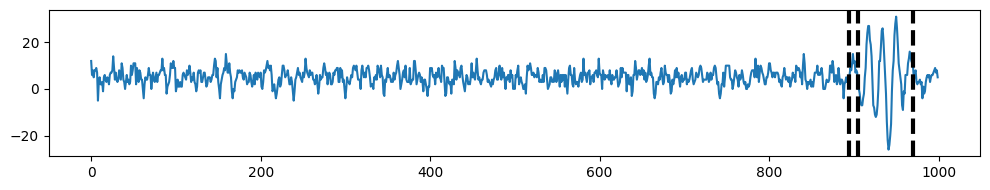

In [ ]:
# ---------- for k = 3 (n_bkps=3) ----------
algo3 = rpt.Dynp(model="rbf").fit(inputData_1000)
result = algo3.predict(n_bkps=3)

rpt.display(eq1.acoustic_data.values[:1000], [], result)
plt.show()


**Figure 10:** The acoustic data from the LANL earthquake prediction data as a function of the number of datapoints is shown for the first 1000 datapoints. The Dynamic programming method is used with the rbf model in Rupture. The Dynamic programming method has a computational complexity of O(kN^2). Three points of change are calculated, seen at ~900, ~910, and ~980 in the x-axis. Visually, the largest “noisy” part of the data is bookmarked by the first and last point of change. From this, the beginning and last point of change can potentially tell us the duration of the earthquake, while the point of change in the middle of the data can potentially be interpreted as a strong shock during the earthquake itself.

Find a method that has computational complexity O(Nlog(N))

Bottom-up segmentation: https://centre-borelli.github.io/ruptures-docs/user-guide/detection/binseg/


Run both methods on the full 10000 rows dataset with the goal is to isolate 3 chunks of the time series. Read about the methods you choose, and describe the constraints you imposed and the paraemters you choose.

In [ ]:
# k = 6 (n_bkps = 6) to try to isolate 3 chunks of the time series
# we choose the model and the n_bkps

# --------------------------

# Dynamic programming method
algo_Dynp_10000 = rpt.Dynp(model="rbf", min_size=100).fit(inputData_10000)
result = algo_Dynp_10000.predict(n_bkps=2)

rpt.display(eq1.acoustic_data.values[:10000], [], result)
plt.show()

KeyboardInterrupt: 

**Note**: we ran this block of code overnight on a local machine, and it finished at ~3 AM on Tuesday April 1st, 2025.

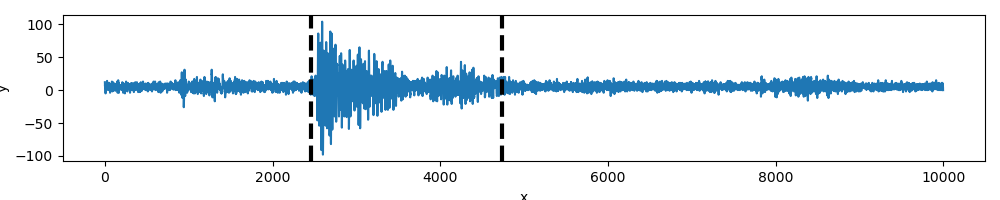

**Figure 10:** The acoustic data from the LANL earthquake prediction data as a function of the number of datapoints is shown for the first 10,000 datapoints. The Dynamic programming method is used with the rbf model in Rupture. The Dynamic programming method has a computational complexity of O(kN^2). Two points of changes are calculated, seen at ~2500 and ~4500 in the x-axis. Visually, the largest “noisy” part of the data is bookmarked by these two points of change. From this, the beginning and last point of change can potentially tell us the duration of the main portion of the earthquake.

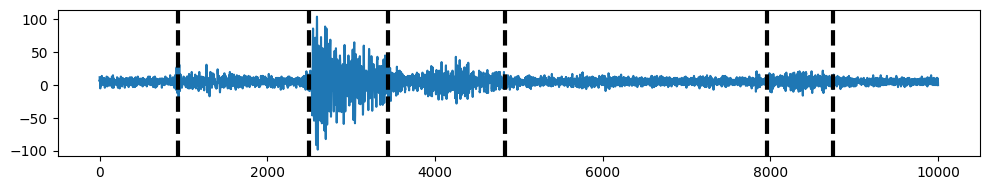

In [ ]:
# --------------------------

# Bottom-up segmentation method
algo_BottomUp_10000 = rpt.BottomUp(model="rbf", min_size=100).fit(inputData_10000)
result = algo_BottomUp_10000.predict(n_bkps=6)

rpt.display(eq1.acoustic_data.values[:10000], [], result)
plt.show()

**Figure 11:** The acoustic data from the LANL earthquake prediction data as a function of the number of datapoints is shown for the first 10,000 datapoints. The Bottom-up method is used as it has a computation complexity of O(nlog(n)) and the rbf model in Rupture. Six points of change are chosen to be calculated in order to ensure sufficient isolation of time series, as only doing exactly three may not pick up on extended behavior of the acoustic data (as seen in particular in Figure 8). These points of change are seen at ~1000, ~2300, ~3400, ~4750, ~7900, and ~8500 in the x-axis of the graph. Six different time series are seen from these points of change calculated. This data along with the points of change can potentially tell us about the different phases of the earthquake and at what points differnet phases start and end.
